# Topic Modeling of Telegram Data using BERTopic
Scraping telegram data is one thing. Another is making sense of the scraped
data. This is a complicated job, as data quantity often is overwhelming.
BERTopic is a topic modelling tool that aims to leverage the capabilities of
vector representations (called embeddings) from state-of-the-art language models
to capture the semantic properties of the underlying data. This makes sorting
large amounts of data for further qualitative readings possible, as well as
provide first qualitative insights into the scraped data.
While BERTopic is relatively straightforward to use, it has a few parameters
that one should be familiarized in order to find meaningful topics. This
Notebook shows how different parametrization affects the found topics and gives
some considerations for other projects that want to analyze (telegram) data
using BERTopic.

## Prepare Google Colab environment

The following code prepares a Google Colab environment (loads the repository and installs the necessary packages)

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !git clone https://github.com/Leibniz-HBI/telegram-workshop-bertopic
    %cd /content/telegram-workshop-bertopic
    !pip install bertopic

## Data Import and preprocessing
Before starting with the actual topic modeling, we have to load and process our
data.
We first load all python packages that we need for the workshop.

Then we load data and do a few pre-processing steps

In [1]:
import pandas as pd
import re
import random
import numpy as np
import pickle
import util # util.py  contains additional code for preprocessing.

# BERTopic and preprocessing steps
from umap import UMAP
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans, SpectralClustering
from sentence_transformers import SentenceTransformer

# pandas disply options
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

#load data
messages_all_df = pd.read_csv('workshop_data.csv')

Typical discourse dynamic in social media produce duplicated items due to
reposting, or parts of a message being copied, such as promotional footers and
so on. In order to get a better insight into the actual discourse, we
deduplicate the dataset. That means that we only keep unique messages for the
topic modelling. Since we still want each message of the dataset to be included
in a cluster, we keep a reference list to all duplicates as well.

In [2]:
# Drop all the empty messages
messages_all_df = messages_all_df.dropna(subset=['message'])
print(f'number of all messages: {len(messages_all_df)}')

# Filter exactly for Lützerath (the keyterm filter on the dataset only contained Lütz*) 
messages_all_df = messages_all_df[messages_all_df['message'].str.contains('Lützerath', case=False, na=False)]
print(f'number of all messages after filtering: {len(messages_all_df)}')

# Before dropping duplicates, create an "addressbook" for reference
messages_all_df['post_id_all'] = messages_all_df.groupby('message')['post_id'].transform(lambda x: ', '.join(x.astype(str)))

# Remove all duplicates
messages_dedup_df = messages_all_df[~messages_all_df["message"].duplicated()].copy()
messages_dedup_df["message"] = messages_dedup_df["message"].astype(str)
print(f'number of all messages after deduplication: {len(messages_dedup_df)}')

number of all messages: 3643
number of all messages after filtering: 2851
number of all messages after deduplication: 1823


### Preprocessing of messages
Raw text data is pretty messy, especially when it is extracted from social media
platforms, where people post unformatted and colloquial messages, containing
hard-to-interpret things like emojis or links. In order to improve results, it is best practice
to do a few preprocessing steps that makes data a bit more uniform.
You can find all preprocessing steps that we've taken in `util.py`.

In [3]:
messages_dedup_df[["created_at", "message"]]

,created_at,message
1,2023-01-08 14:03:36,"���� AMPEL FÖRDERT RADIKALISIERUNG:\n\nIn Lützerath heißt Grüne Randale ziviler Ungehorsam\n\nAktivisten und Extremisten, die Grenze zwischen beiden verfließt immer mehr, kamen nach Lützerath und besetzten das leerstehende Dorf. Inzwischen hat sich ein sogenanntes Aktionsbündnis unter dem Namen „Lützerath unräumbar“ gebildet, zu dem NGOs wie „Fridays for Future“, „Ende Gelände“ und natürlich, die teils aus den USA finanzierte „Letzte Generation“ gehören. \n\nhttps://www.tichyseinblick.de/meinungen/luetzerath-raeumung-radikalisierung/ \n\nBitte abonniert Schuberts Lagemeldung: https://t.me/SchubertsLM"
2,2023-01-12 15:43:43,"Lebensgefahr? Klima-Extremisten haben Tunnel gebaut\n\nWie Klima-Extremisten von „LütziBleibt“ behaupten, haben sie in Lützerath unterirdische Tunnel angelegt, in denen sie sich verschanzen wollen, um die Räumung zu erschweren. „In Lützi im Wäldchen gibt es einen Tunnel mit Menschen drin. Nicht mit schwerem Gerät ins Wäldchen & Bereich der Straße fahren — der Tunnel stürzt sonst ein. Es besteht akute Lebensgefahr“, schreibt der „Aktionsticker Lützerath“\n\nhttps://pleiteticker.de/pleiteticker-vor-ort-polizei-raeumt-luetzerath/\n\nBitte abonniert Schuberts Lagemeldung: https://t.me/SchubertsLM"
3,2023-01-13 07:33:32,"Grünen-Politiker demonstrieren gegen Lützerath-Räumung, stimmten im Bundestag zuvor dafür\n\nWährend sich in den letzten Tagen immer mehr grünen Politiker mit den Aktionen der Klima-Extremisten in Lützerath solidarisieren, scheinen viele bequemerweise vergessen zu haben, dass sie selbst im Bundestag für den Kompromiss stimmten, der eine solche Räumung beinhaltete. \n\nUnd das vor kaum mehr als einem Monat, am 1. Dezember 2022. Kein einziger Abgeordneter der Grünen stimmte dagegen. Aber heute scheint das alles vergessen zu sein.\n\nNyke Slawik, MdB für die Grünen, schreibt auf Twitter davon, dass die Räumung Lützerath gestoppt werden müsse. Gleichzeitig war es Slawik, der zuvor für das entsprechende Gesetz stimmte.\n\nhttps://pleiteticker.de/gruenen-politiker-demonstrieren-gegen-luetzerath-raeumung-stimmten-im-bundestag-zuvor-dafuer/\n\nBitte abonniert Schuberts Lagemeldung: https://t.me/SchubertsLM"
4,2023-05-17 07:12:15,"„Cops töten“: Polizei-Papier offenbart die Aggressivität der Klima-Aktivisten \n\nDie Aktionen der „Letzten Generation“ und „Extinction Rebellion“ sind mittlerweile auch in der Kriminalstatistik zu erkennen, in NRW wurden dieses Jahr bereits 94 Delikte gemeldet. Dazu kommen noch viele Taten, die die Polizei bei der Räumung des Dorfes Lützerath verzeichnete. \n\nSeit 2020 registrierte das NRW-Innenministerium knapp 800 Delikte, die im Kontext zu rechtswidrigen Protesten von Gruppierungen wie die „Letzte Generation“, „Extinction Rebellion“ oder auch anderer Protagonisten stehen. \n\nhttps://www.focus.de/politik/deutschland/so-wirken-sich-klimaproteste-auf-die-strafstatistik-aus_id_193850526.html \n\nBitte abonniert Schuberts Lagemeldung: https://t.me/SchubertsLM"
5,2023-01-12 15:03:28,"Aktivistin aus Autowrack geholt \n\nPolizei setzt Räumung von Lützerath fort\n\nEinen Tag braucht die Polizei, um Lützerath zu umzäunen und damit den Zugang zum Braunkohle-Dorf zu erschweren. Nun sollen auch die letzten verbliebenen Aktivisten aus dem Ort herausgeholt werden. Doch die wehren sich mit drastischen Mitteln.\n\nEinsatzkräfte drangen am Morgen in ein Gehöft ein. Sie sägten ein Loch in ein Tor und verschafften sich dadurch Zutritt. An dem Gehöft hängt ein großes gelbes Banner mit der Aufschrift ""1,5°C heißt: Lützerath bleibt!"". Einige Aktivisten, die drinnen waren, wurden weggebracht.\n\nUnterdessen hat die Polizei einen neuen, anderthalb Kilometer langen Zaun zur Umfriedung Lützeraths fast vollendet. Nur die Tore fehlten noch, sagte ein RWE-Konzernsprecher am Morgen. Die Tore sollen im Laufe des Tages eingehängt werden. \n\nhttps://www.n-tv.de/politik/Polizei-setzt-Raeumung-von-Luetzerath-fort-article23838949.html\n\nBitte abonniert Schuberts

In [4]:
# Here, we can apply a preprocessing step to prune footer lines from messages.
# This is achieved in a right heuristic that removes all duplicate paragraphs from the dataset
# --
# messages_dedup_df = util.deduplicate_message_lines(messages_dedup_df)
# messages_dedup_df

In [5]:
# standard preprocessing: removal of URLs, emojies, ...
messages_dedup_df["processed"] = util.preprocess_workshop_data(messages_dedup_df.message)
messages_dedup_df = messages_dedup_df[messages_dedup_df['processed'].str.strip() != '']
messages_dedup_df[["created_at", "message", "processed"]]

,created_at,message,processed
1,2023-01-08 14:03:36,"���� AMPEL FÖRDERT RADIKALISIERUNG:\n\nIn Lützerath heißt Grüne Randale ziviler Ungehorsam\n\nAktivisten und Extremisten, die Grenze zwischen beiden verfließt immer mehr, kamen nach Lützerath und besetzten das leerstehende Dorf. Inzwischen hat sich ein sogenanntes Aktionsbündnis unter dem Namen „Lützerath unräumbar“ gebildet, zu dem NGOs wie „Fridays for Future“, „Ende Gelände“ und natürlich, die teils aus den USA finanzierte „Letzte Generation“ gehören. \n\nhttps://www.tichyseinblick.de/meinungen/luetzerath-raeumung-radikalisierung/ \n\nBitte abonniert Schuberts Lagemeldung: https://t.me/SchubertsLM","AMPEL FÖRDERT RADIKALISIERUNG: In heißt Grüne Randale ziviler Ungehorsam Aktivisten und Extremisten, die Grenze zwischen beiden verfließt immer mehr, kamen nach und besetzten das leerstehende Dorf. Inzwischen hat sich ein sogenanntes Aktionsbündnis unter dem Namen „ unräumbar“ gebildet, zu dem NGOs wie „Fridays for Future“, „Ende Gelände“ und natürlich, die teils aus den USA finanzierte „Letzte Generation“ gehören. Bitte abonniert Schuberts Lagemeldung:"
2,2023-01-12 15:43:43,"Lebensgefahr? Klima-Extremisten haben Tunnel gebaut\n\nWie Klima-Extremisten von „LütziBleibt“ behaupten, haben sie in Lützerath unterirdische Tunnel angelegt, in denen sie sich verschanzen wollen, um die Räumung zu erschweren. „In Lützi im Wäldchen gibt es einen Tunnel mit Menschen drin. Nicht mit schwerem Gerät ins Wäldchen & Bereich der Straße fahren — der Tunnel stürzt sonst ein. Es besteht akute Lebensgefahr“, schreibt der „Aktionsticker Lützerath“\n\nhttps://pleiteticker.de/pleiteticker-vor-ort-polizei-raeumt-luetzerath/\n\nBitte abonniert Schuberts Lagemeldung: https://t.me/SchubertsLM","Lebensgefahr. Klima-Extremisten haben Tunnel gebaut Wie Klima-Extremisten von „ behaupten, haben sie in unterirdische Tunnel angelegt, in denen sie sich verschanzen wollen, um die Räumung zu erschweren. „In im Wäldchen gibt es einen Tunnel mit Menschen drin. Nicht mit schwerem Gerät ins Wäldchen & Bereich der Straße fahren — der Tunnel stürzt sonst ein. Es besteht akute Lebensgefahr“, schreibt der „Aktionsticker Bitte abonniert Schuberts Lagemeldung:"
3,2023-01-13 07:33:32,"Grünen-Politiker demonstrieren gegen Lützerath-Räumung, stimmten im Bundestag zuvor dafür\n\nWährend sich in den letzten Tagen immer mehr grünen Politiker mit den Aktionen der Klima-Extremisten in Lützerath solidarisieren, scheinen viele bequemerweise vergessen zu haben, dass sie selbst im Bundestag für den Kompromiss stimmten, der eine solche Räumung beinhaltete. \n\nUnd das vor kaum mehr als einem Monat, am 1. Dezember 2022. Kein einziger Abgeordneter der Grünen stimmte dagegen. Aber heute scheint das alles vergessen zu sein.\n\nNyke Slawik, MdB für die Grünen, schreibt auf Twitter davon, dass die Räumung Lützerath gestoppt werden müsse. Gleichzeitig war es Slawik, der zuvor für das entsprechende Gesetz stimmte.\n\nhttps://pleiteticker.de/gruenen-politiker-demonstrieren-gegen-luetzerath-raeumung-stimmten-im-bundestag-zuvor-dafuer/\n\nBitte abonniert Schuberts Lagemeldung: https://t.me/SchubertsLM","Grünen-Politiker demonstrieren gegen stimmten im Bundestag zuvor dafür Während sich in den letzten Tagen immer mehr grünen Politiker mit den Aktionen der Klima-Extremisten in solidarisieren, scheinen viele bequemerweise vergessen zu haben, dass sie selbst im Bundestag für den Kompromiss stimmten, der eine solche Räumung beinhaltete. Und das vor kaum mehr als einem Monat, am 1. Dezember 2022. Kein einziger Abgeordneter der Grünen stimmte dagegen. Aber heute scheint das alles vergessen zu sein. Nyke Slawik, MdB für die Grünen, schreibt auf Twitter davon, dass die Räumung gestoppt werden müsse. Gleichzeitig war es Slawik, der zuvor für das entsprechende Gesetz stimmte. Bitte abonniert Schuberts Lagemeldung:"
4,2023-05-17 07:12:15,"„Cops töten“: Polizei-Papier offenbart die Aggressivität der Klima-Aktivisten \n\nDie Aktionen der „Letzten Generation“ un

In [6]:
# convert column of docs to a list
documents = messages_dedup_df.processed.to_list()

## BERTopic

### Embeddings

In [7]:
sbert_model = "paraphrase-multilingual-mpnet-base-v2"
# Extract embeddings
model = SentenceTransformer(sbert_model)

In [8]:
if not IN_COLAB:
    # Calculating Sentence-BERT embeddings might take a long time ...
    embeddings = model.encode(documents, batch_size=64, show_progress_bar=True)
    # ... so we save them for later use
    pickle.dump(embeddings, open("telegram_data_embeddings.pkl", "wb"))

Batches:   0%|          | 0/29 [00:00<?, ?it/s]

In [9]:
# ... and load them instead of recomputing them all the time
embeddings = pickle.load(open("telegram_data_embeddings.pkl", "rb"))
len(embeddings)

1816

In [10]:
# this is the first document as embedding
print("Text:\n", documents[0])
print("Embedding:\n", embeddings[0].round(2))

Text:
 AMPEL FÖRDERT RADIKALISIERUNG: In heißt Grüne Randale ziviler Ungehorsam Aktivisten und Extremisten, die Grenze zwischen beiden verfließt immer mehr, kamen nach und besetzten das leerstehende Dorf. Inzwischen hat sich ein sogenanntes Aktionsbündnis unter dem Namen „ unräumbar“ gebildet, zu dem NGOs wie „Fridays for Future“, „Ende Gelände“ und natürlich, die teils aus den USA finanzierte „Letzte Generation“ gehören. Bitte abonniert Schuberts Lagemeldung:
Embedding:
 [-0.11  0.18 -0.01  0.02 -0.   -0.09  0.06 -0.02  0.15  0.1   0.16  0.06
 -0.08 -0.13 -0.01  0.05 -0.01  0.04 -0.11 -0.    0.01 -0.06  0.08  0.05
  0.02  0.01 -0.13 -0.01  0.17 -0.02  0.14 -0.04 -0.03  0.13  0.05  0.05
  0.01 -0.03 -0.01 -0.06  0.01 -0.12 -0.14  0.02 -0.23 -0.14  0.03 -0.02
 -0.01  0.01  0.04  0.13  0.04  0.12  0.06  0.15 -0.03 -0.05  0.12 -0.12
  0.04  0.06 -0.03 -0.04 -0.05 -0.08 -0.1   0.03 -0.18 -0.12  0.15  0.16
 -0.09  0.12 -0.02  0.07 -0.   -0.07 -0.    0.05 -0.05 -0.07 -0.01  0.07
 -0.11  0.1 

## Getting rid of Stopwords

In [11]:
with open("stopwords_de_extended.txt") as file:
    stopwords_de = [line.rstrip() for line in file]

with open("stopwords_en.txt") as file:
    stopwords_en = [line.rstrip() for line in file]

# create a vactorizer for the cf-tfidf part of BERTopic to ignore stopwords during keyterm etraction 
stopwords = list(set(stopwords_de + stopwords_en))
vectorizer_model = CountVectorizer(lowercase=True, stop_words = stopwords)

### Topic Model Spezifikation

In [12]:
# Create a reproducible topic model
def run_bertopic(num_topics, min_topic_size, min_samples=None, random_state=1235234):
    # make the model reprodicible by fixing random seeds
    random.seed(random_state)
    np.random.seed(random_state)

    # model to compute dimension reduction of embeddings
    umap_model = UMAP(
        n_neighbors=15,
        n_components=5,
        min_dist=0.0,
        metric='cosine',
        random_state=random_state
    )

    # cluster algorithm to cluster documents
    cluster_model = HDBSCAN(
        min_cluster_size=min_topic_size,
        metric='euclidean',
        cluster_selection_method='eom',
        prediction_data=True,
        min_samples=min_samples
    )

    # BERTopic instance that utilizes the UMAP and the cluster model
    topic_model = BERTopic(
        embedding_model=sbert_model,
        language="german",
        vectorizer_model=vectorizer_model,
        nr_topics = num_topics, # "auto",
        min_topic_size = min_topic_size,
        calculate_probabilities=False,
        hdbscan_model=cluster_model,
        umap_model=umap_model,
        # low_memory=True,
        verbose=True
    )

    # Fit a model to a set of documents and embeddings and extract topics
    topics, probs = topic_model.fit_transform(
        documents=documents,
        embeddings=embeddings
    )
    print("Number of topics:", len(topics))
    print("Number of probabilities:", len(probs))

    print("The topic model for " + str(num_topics) + " topics is ready.")

    return topic_model, topics, probs

In [17]:
# Run the model. You can test different parameters for BERTopic 
# We found run_bertopic(num_topics=15, min_topic_size=20, min_samples=10) to be a good option
topic_model, topics, probs = run_bertopic(num_topics=15, min_topic_size=20, min_samples=10)

2024-01-22 20:44:07,615 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-01-22 20:44:12,090 - BERTopic - Dimensionality - Completed ✓
2024-01-22 20:44:12,091 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-01-22 20:44:12,128 - BERTopic - Cluster - Completed ✓
2024-01-22 20:44:12,128 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-01-22 20:44:12,262 - BERTopic - Representation - Completed ✓
2024-01-22 20:44:12,263 - BERTopic - Topic reduction - Reducing number of topics
2024-01-22 20:44:12,396 - BERTopic - Topic reduction - Reduced number of topics from 18 to 15


Number of topics: 1816
Number of probabilities: 1816
The topic model for 15 topics is ready.


In [18]:
topic_model.get_topic_info().drop(columns=["Representative_Docs"])

,Topic,Count,Name,Representation
0,-1,691,-1_polizei_aktivisten_räumung_klima,"[polizei, aktivisten, räumung, klima, 2023, demonstranten, rwe, 01, menschen, polizisten]"
1,0,223,0_klima_klimaterroristen_polizei_aktivisten,"[klima, klimaterroristen, polizei, aktivisten, cocktails, molotow, polizisten, klimaterror, terroristen, nrw]"
2,1,159,1_grünen_grüne_rwe_bundestag,"[grünen, grüne, rwe, bundestag, räumung, grüner, klima, henneberger, partei, kohle]"
3,2,155,2_rwe_kohle_dorf_garzweiler,"[rwe, kohle, dorf, garzweiler, räumung, menschen, infos, ort, bleiben, tagebau]"
4,3,136,3_polizei_räumung_polizisten_2023,"[polizei, räumung, polizisten, 2023, einsatzkräfte, barrikaden, schlamm, police, besetzer, aktivisten]"
5,4,104,4_greta_thunberg_polizei_verhaftung,"[greta, thunberg, polizei, verhaftung, fake, medien, schwedische, klimaaktivistin, video, festnahme]"
6,5,62,5_demo_leipzig_tag_01,"[demo, leipzig, tag, 01, ag, gemeinsam, freuen, platz, village, gerne]"
7,6,52,6_antifa_polizei_gewalt_journalisten,"[antifa, polizei, gewalt, journalisten, staat, terrorgruppen, gewalttäter, erleben, klima, terror]"
8,7,50,7_apple_unwort_jahres_schlacht,"[apple, unwort, jahres, schlacht, youtube, schlamm, podcasts, schabernack, hashtags, lützerath]"
9,8,50,8_akw_18_30_grünen,"[akw, 18, 30, grünen, 15, platz, 19, kwh, prof, 17]"


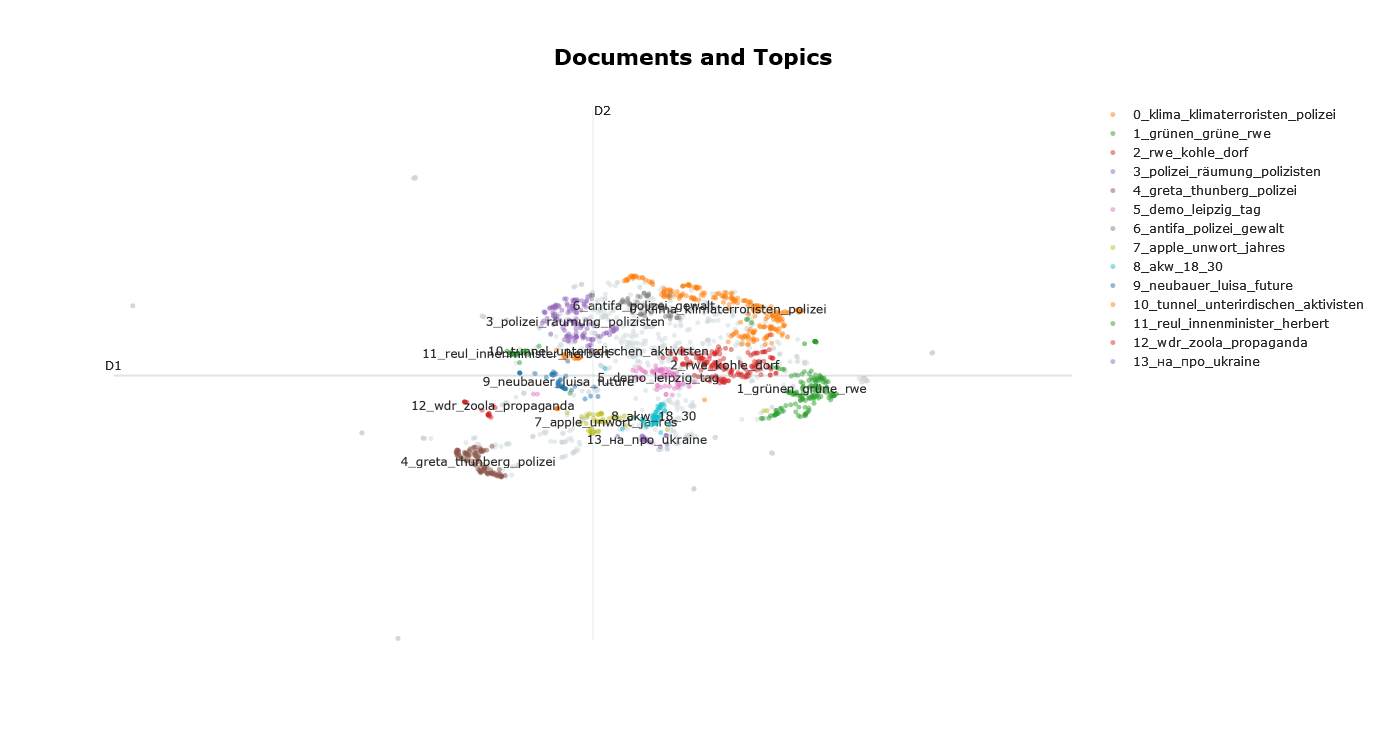

In [19]:
# Run the visualization with the original embeddings
topic_model.visualize_documents(documents, embeddings=embeddings)

In [21]:
# Export for thorough evaluation
util.export_topic_results(topic_model, topics, probs, messages_all_df, messages_dedup_df, 'results')